<a href="https://colab.research.google.com/github/navavatpi/researchPhd/blob/developANN/3_dataModelingANNModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Data Modeling: ANN model

## Environment Setup

In [ ]:
# Enabling and testing the TPU
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.6.0
Running on TPU  ['10.82.128.234:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.82.128.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.82.128.234:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
# install scikit-plot to Colab
!pip install scikit-plot

In [ ]:
# libraries import
import os # miscellaneous operating system interfaces
import numpy as np # Array library for linear algebra
import matplotlib.pyplot as plt # visualization library
from sklearn.metrics import classification_report # evaluators classification report
import scikitplot as skplt # scikit-learn and matplotlib integrated visualization library
from tensorflow import keras # back-end artificial neural network API
from tensorflow.keras import layers # layer API for neural network architechture
from tensorflow.keras.optimizers import Adam # optimizer in neural network implement
from tensorflow.keras.callbacks import ReduceLROnPlateau # Reduce learning rate when a metric has stopped improving
from keras.models import model_from_json # loading model in JSON format

# system configuration
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0" # disable warning messages
os.environ['AUTOGRAPH_VERBOSITY'] = '0' # set it to 0
random_seed = 20 # random seed

In [ ]:
# connect to google drive to obtain dataset
# !note: need to perform authorization by following below link
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading

In [ ]:
# define path to files
defaultdir = '/content/drive/My Drive/all_about_phd_research/'

In [ ]:
# load input data from drive
X_train = np.load(defaultdir + '/processed_data/X_train.npy')
X_test = np.load(defaultdir + '/processed_data/X_test.npy')
y_train = np.load(defaultdir + '/processed_data/y_train.npy')
y_test = np.load(defaultdir + '/processed_data/y_test.npy')

## Data Modeling

In [ ]:
# define function to create CNN model
def cnnModel(data_train, num_classes, layer=1, x_filter= 64, 
             kernel_size= (3,3), pool_size=(2,2), drop_size=0.5, 
             ):
    
    # input layer convert arrays => tensors
    inputs = keras.Input(data_train.shape[1:]) # dimension of the input

    x1 = layers.Conv2D(filters = x_filter, 
                       kernel_size = kernel_size, 
                       padding = 'Same', 
                       activation ='relu')(inputs)
    x1 = layers.Conv2D(filters = x_filter, 
                       kernel_size = kernel_size, 
                       padding = 'Same', 
                       activation ='relu')(x1)
    x1 = layers.MaxPool2D(pool_size= pool_size)(x1)
    x1 = layers.Dropout(drop_size)(x1)
    
    dense_size = x_filter
    
    if layer > 1:
        
        x1 = layers.Conv2D(filters = 2*x_filter, 
                           kernel_size = kernel_size, 
                           padding = 'Same', 
                           activation ='relu')(x1)
        x1 = layers.Conv2D(filters = 2*x_filter, 
                           kernel_size = kernel_size, 
                           padding = 'Same', 
                           activation ='relu')(x1)
        x1 = layers.MaxPool2D(pool_size= pool_size)(x1)
        x1 = layers.Dropout(drop_size)(x1)
        
        dense_size = 2*x_filter
        
        if layer > 2:

            x1 = layers.Conv2D(filters = 4*x_filter, 
                               kernel_size = kernel_size, 
                               padding = 'Same', 
                               activation ='relu')(x1)
            x1 = layers.Conv2D(filters = 4*x_filter, 
                               kernel_size = kernel_size, 
                               padding = 'Same', 
                               activation ='relu')(x1)
            x1 = layers.MaxPool2D(pool_size= pool_size)(x1)
            x1 = layers.Dropout(drop_size)(x1)
            
            dense_size = 4*x_filter
            
            if layer > 3:

                x1 = layers.Conv2D(filters = 8*x_filter, 
                                   kernel_size = kernel_size, 
                                   padding = 'Same', 
                                   activation ='relu')(x1)
                x1 = layers.Conv2D(filters = 8*x_filter, 
                                   kernel_size = kernel_size, 
                                   padding = 'Same', 
                                   activation ='relu')(x1)
                x1 = layers.MaxPool2D(pool_size= pool_size)(x1)
                x1 = layers.Dropout(drop_size)(x1)
                
                dense_size = 8*x_filter
                
                if layer > 4:

                    x1 = layers.Conv2D(filters = 8*x_filter, 
                                       kernel_size = kernel_size, 
                                       padding = 'Same', 
                                       activation ='relu')(x1)
                    x1 = layers.Conv2D(filters = 8*x_filter, 
                                       kernel_size = kernel_size, 
                                       padding = 'Same', 
                                       activation ='relu')(x1)
                    x1 = layers.MaxPool2D(pool_size= pool_size)(x1)
                    x1 = layers.Dropout(drop_size)(x1)
                    
                    dense_size = 8*x_filter

    x2 = layers.Flatten()(x1)
    x2 = layers.Dense(dense_size, activation = "relu")(x2)

    outputs = layers.Dense(num_classes, activation= "softmax")(x2)

    cnnModel = keras.Model(inputs=inputs, outputs=outputs, name="cnnModel")

    cnnModel.summary()
    
    return cnnModel

In [ ]:
# perform CNN model define function
cnnModel = cnnModel(X_train, layer=2, num_classes=3)

Model: "cnnModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 330, 640, 224)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, 330, 640, 64)      129088    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 330, 640, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 165, 320, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 165, 320, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 165, 320, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 165, 320, 128)     147

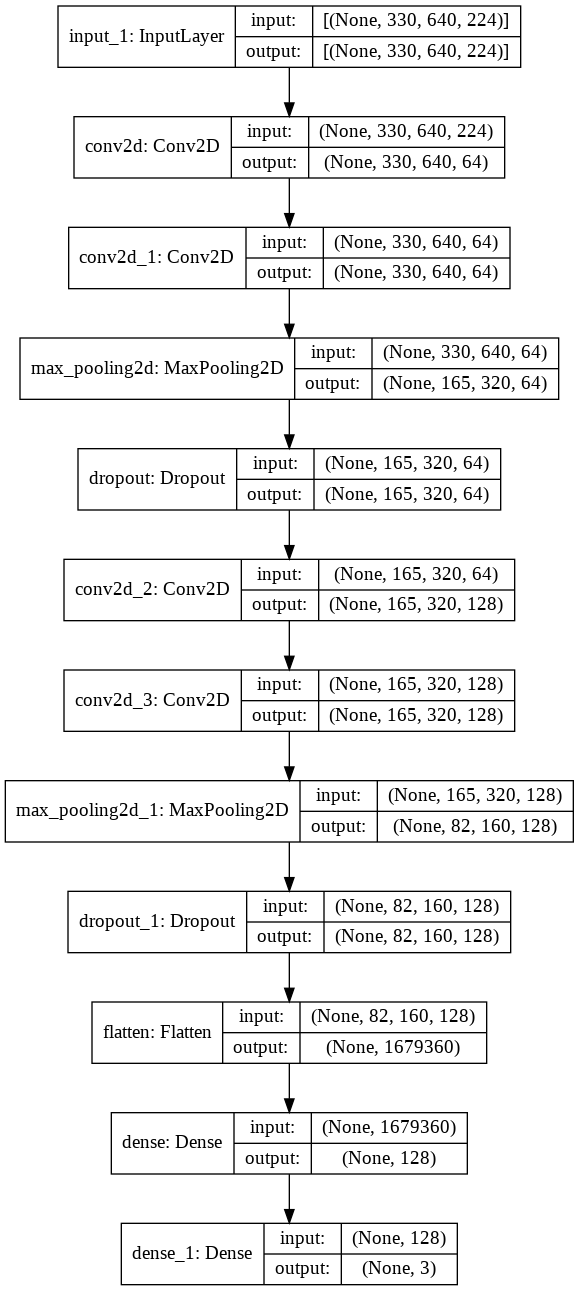

In [ ]:
# plot CNN model architecture
# the figure will be saved in the same directory with input datas
tf.keras.utils.plot_model(cnnModel, 
                          to_file=defaultdir + '/processed_data/model.png', 
                          show_shapes=True)

In [ ]:
# define ADAM opimizer & complie then train the model function
def modelComplie(cnnModel, X_train, y_train, 
             X_test, y_test,
             epochs, batch_size, 
             learning_rate=0.001, beta_1=0.9, beta_2=0.999, 
             epsilon=1e-08, decay=0):

  # Define the optimizer
  optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, 
                   epsilon=epsilon, decay=decay)

  # assign metrics for the model
  cnnModel.compile(optimizer=optimizer , 
                   loss="categorical_crossentropy", 
                   metrics=["accuracy"])

## Model Training

In [ ]:
# define training epoch number & batch size  parameters
epochs_list = [5]
batch_size_list = [5]

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                          patience=3, 
                                          verbose=1, 
                                          factor=0.5, 
                                          min_lr=0.00001)
  
# loop for training model
for epochs in epochs_list:
  for batch_size in batch_size_list:

    # perform compile model function
    modelComplie(cnnModel=cnnModel, X_train=X_train, y_train=y_train, 
         X_test=X_test, y_test=y_test, 
         epochs=epochs, batch_size=batch_size)
    
    print('Model is training in total =', epochs, 'epochs')
    print('In each epoch has batch size =', batch_size, 'samples')
    
    
    # training model with learning rate annealer
    history = cnnModel.fit(X_train, y_train, 
                         batch_size=batch_size,
                         epochs = epochs, 
                         validation_data = (X_test,y_test),
                         verbose = 1, 
                         steps_per_epoch=X_train.shape[0]//batch_size,
                         callbacks=[learning_rate_reduction])
    
    print('CNN model has done training')

Model is training in total = 5 epochs
In each epoch has batch size = 5 samples
Epoch 1/5
3/3 [==============================] - 26s 10s/step - loss: 537.8196 - accuracy: 0.3333 - val_loss: 11.3190 - val_accuracy: 0.3333
Epoch 2/5
3/3 [==============================] - 11s 4s/step - loss: 35.1639 - accuracy: 0.4167 - val_loss: 2.4918 - val_accuracy: 0.1667
Epoch 3/5
3/3 [==============================] - 11s 4s/step - loss: 2.0833 - accuracy: 0.5833 - val_loss: 1.0545 - val_accuracy: 0.5000
Epoch 4/5
3/3 [==============================] - 11s 4s/step - loss: 1.2639 - accuracy: 0.3333 - val_loss: 1.1208 - val_accuracy: 0.1667
Epoch 5/5
3/3 [==============================] - 13s 4s/step - loss: 1.1334 - accuracy: 0.3333 - val_loss: 1.1215 - val_accuracy: 0.1667


## Model Prediction
### Note:
At this stage, we have 5 datasets and 1 model which are
1. X_train: training dataset
2. X_test: testing dataset
3. y_train: training label
4. y_test: testing label
5. y_pred: prediction label from model
6. cnnModel: CNN model

In [ ]:
# making predictions
y_pred = cnnModel.predict(X_test, verbose=1)

print('CNN model has done making prediction')

1/1 [==============================] - 1s 807ms/step


# Model Evaluation

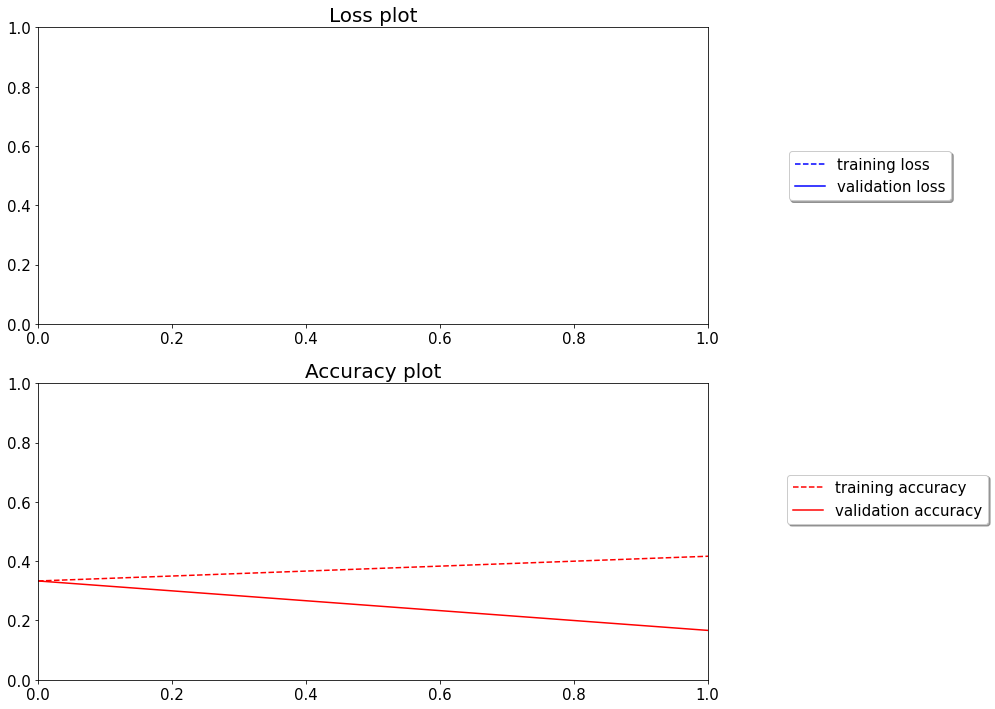

In [ ]:
# Plot the loss & accuracy curves for training and validation
# Define number of plots -> 2
figurename = 'Loss and Accuracy plot'

plt.figure(figsize=(12,12))
plt.tight_layout()

# set font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

# -------------------------------------------------------------------------------------------------------------------------------
# Loss plot
plt.subplot(2,1,1)
plt.plot(history.history['loss'], '--', color='b', label="training loss")
plt.plot(history.history['val_loss'], '-', color='b', label="validation loss")

# decorating
plt.axis([0, 1, 0, 1]) # define lower & upper boundaries of axes ([x-axis, y-axis])
legend = plt.legend(loc='center right', shadow=True, bbox_to_anchor=(1.375, 0.5), ncol=1,fontsize=MEDIUM_SIZE)
plt.title('Loss plot', fontsize=BIGGER_SIZE)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)

# -------------------------------------------------------------------------------------------------------------------------------
# Accuracy plot
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'], '--', color='r', label="training accuracy")
plt.plot(history.history['val_accuracy'], '-', color='r',label="validation accuracy")

# decorating
plt.axis([0, 1, 0, 1]) # define lower & upper boundaries of axes ([x-axis, y-axis])
legend = plt.legend(loc='lower right', shadow=True, bbox_to_anchor=(1.43, 0.5), ncol=1, fontsize=MEDIUM_SIZE)
plt.title('Accuracy plot', fontsize=BIGGER_SIZE)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)

# plt.subplots_adjust(hspace=0.5)

# save figure
plt.savefig(defaultdir + '/processed_data/' + figurename + '.png')

## Confusion matrix and AUC-ROC curve

In [ ]:
# def plot confusion matrix function
def plotConfusionMatrix(y_test=y_test, y_pred=y_pred, title='Confusion Matrix of CNN model'):

  # set font sizes
  SMALL_SIZE = 12
  MEDIUM_SIZE = 15
  BIGGER_SIZE = 20

  skplt.metrics.plot_confusion_matrix(y_true=np.argmax(y_test, axis=1), 
                                      y_pred=np.argmax(y_pred, axis=1), 
                                      title=title, 
                                      normalize='true', 
                                      figsize=(9,9), 
                                      cmap=plt.cm.Reds, 
                                      title_fontsize= BIGGER_SIZE, 
                                      text_fontsize= BIGGER_SIZE
                                      )

  # save figure
  plt.savefig(defaultdir + '/processed_data/' + title + '.png')

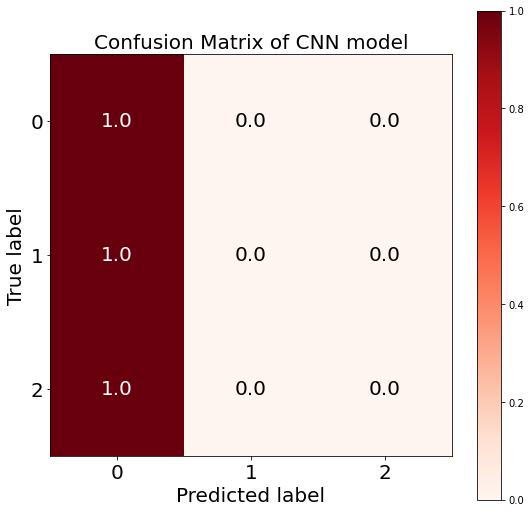

In [ ]:
# perform plot confusion matrix function
title = 'Confusion Matrix of CNN model'
plot = plotConfusionMatrix(y_test=y_test, y_pred=y_pred, title=title)

In [ ]:
# def plot ROC curve function
def plotROC(y_test=y_test, y_pred=y_pred, title='ROC curve of CNN model'):

  # set font sizes
  SMALL_SIZE = 12
  MEDIUM_SIZE = 15
  BIGGER_SIZE = 20

  skplt.metrics.plot_roc(y_true=np.argmax(y_test, axis=1), 
                                      y_probas=y_pred, 
                                      title=title, 
                                      plot_micro=True, 
                                      plot_macro=True, 
                                      figsize=(12,6), 
                                      cmap=plt.cm.Reds, 
                                      title_fontsize= BIGGER_SIZE, 
                                      text_fontsize= MEDIUM_SIZE
                         )

  # save figure
  plt.savefig(defaultdir + '/processed_data/' + title + '.png')

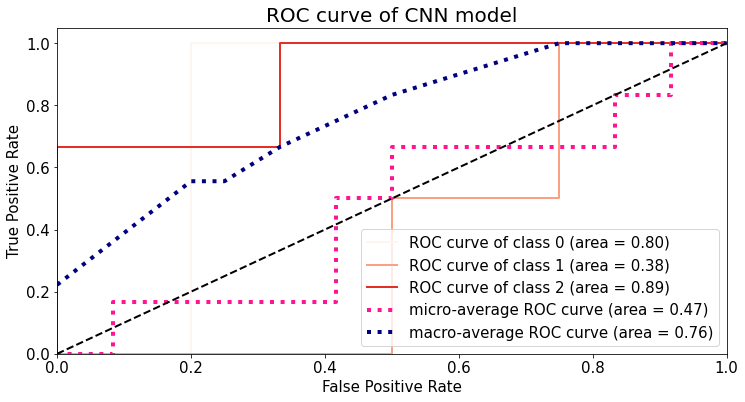

In [ ]:
# perform plot ROC curve function
title = 'ROC curve of CNN model'
plot = plotROC(y_test=y_test, y_pred=y_pred, title=title)

## Print Classification Report

In [ ]:
# classification report
num_classes = 3
class_list = ['class '+ str(y_class) for y_class in range(num_classes)]

print(classification_report(np.argmax(y_test,axis=1), 
                            np.argmax(y_pred,axis=1), 
                            target_names= class_list))

              precision    recall  f1-score   support

     class 0       0.17      1.00      0.29         1
     class 1       0.00      0.00      0.00         2
     class 2       0.00      0.00      0.00         3

    accuracy                           0.17         6
   macro avg       0.06      0.33      0.10         6
weighted avg       0.03      0.17      0.05         6



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Saving model

In [ ]:
# define saving function
def save_model (model, model_name):

    # serialize model to JSON
    model_json = model.to_json()
    
    with open("{}.json".format(defaultdir + '/processed_data/' + model_name), "w") as json_file:
        
        json_file.write(model_json)

        # serialize weights to HDF5
        model.save_weights("{}_weight.h5".format(defaultdir + '/processed_data/' + model_name))

    print("Saved {} to drive".format(model_name))

In [ ]:
# perform saving
save_model(model=cnnModel, model_name='cnnModel')

Saved cnnModel to drive


## Load the saved model

In [ ]:
# define loading function
def load_model (model, model_name):

    # load json and create model
    json_file = open('{}.json'.format(defaultdir + '/processed_data/' + model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights("{}_weight.h5".format(defaultdir + '/processed_data/' + model_name))
    print("Loaded {} from drive".format(model_name))
    
    return loaded_model

In [ ]:
# perform loading
cnnModel = load_model(model=cnnModel, model_name='cnnModel')

Loaded cnnModel from drive


## Perform testing loaded model

In [ ]:
# perform compile model function
modelComplie(cnnModel=cnnModel, X_train=X_train, y_train=y_train, 
         X_test=X_test, y_test=y_test, 
         epochs=epochs, batch_size=batch_size)

# evaluate the loaded model
cnnModel.evaluate(X_train, y_train, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 1.0311 - accuracy: 0.4706


[1.031050682067871, 0.47058823704719543]

In [ ]:
# making prediction of loaded model
cnnModel.predict(X_test, verbose=1)

1/1 [==============================] - 1s 862ms/step


array([[0.3833074 , 0.27347785, 0.34321475],
       [0.43321398, 0.27318636, 0.29359964],
       [0.3986328 , 0.27468222, 0.32668495],
       [0.41644436, 0.28124335, 0.30231228],
       [0.40828285, 0.2730677 , 0.31864944],
       [0.3722127 , 0.2779635 , 0.3498238 ]], dtype=float32)

# Finish Data life cycle